# Airline Tweets Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from collections import Counter
from sklearn.metrics import normalized_mutual_info_score
from numpy import split
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD 
from sklearn.svm import SVR
from xgboost import XGBRegressor

### Note: Since we want to predict the likelihood of negative tweets in the future rather than the actual sentiment for each tweet, I won't perform a traditional sentiment analysis in the field of NLP. If you're interested in my NLP skills, check it out in my github: https://github.com/RoyZihao?tab=repositories

## Data

In [2]:
data = pd.read_csv('Tweets.csv')

In [3]:
data.shape

(14640, 15)

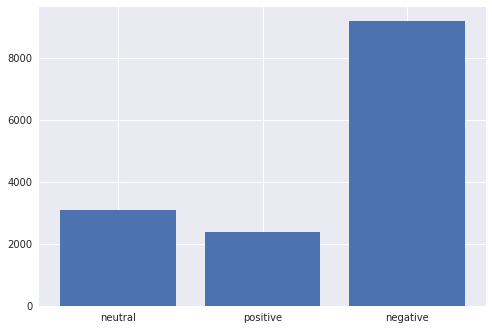

In [4]:
count = Counter(data.airline_sentiment)
with plt.style.context(('seaborn')):
    plt.bar(count.keys(), count.values())

We can see there are majority negative sentiment, which makes sense because people tend to post comment online when they believe they are mistreated

In [5]:
def df_property(df):
    return pd.DataFrame({'data_type': [type(df[col][0]) for col in df.columns],
            'number_nan':df.isna().sum(),
            'number_distinct':[df[col].nunique() for col in df.columns],
            'distinct vals': [df[col].unique() for col in df.columns]})

In [6]:
df_property(data)

,data_type,number_nan,number_distinct,distinct vals
tweet_id,<class 'numpy.int64'>,0,14485,"[570306133677760513, 570301130888122368, 57030..."
airline_sentiment,<class 'str'>,0,3,"[neutral, positive, negative]"
airline_sentiment_confidence,<class 'numpy.float64'>,0,1023,"[1.0, 0.3486, 0.6837, 0.6745, 0.634, 0.6559, 0..."
negativereason,<class 'float'>,5462,10,"[nan, Bad Flight, Can't Tell, Late Flight, Cus..."
negativereason_confidence,<class 'numpy.float64'>,4118,1410,"[nan, 0.0, 0.7033, 1.0, 0.6842, 0.3684, 0.3614..."
airline,<class 'str'>,0,6,"[Virgin America, United, Southwest, Delta, US ..."
airline_sentiment_gold,<class 'float'>,14600,3,"[nan, negative, neutral, positive]"
name,<class 'str'>,0,7701,"[cairdin, jnardino, yvonnalynn, cjmcginnis, pi..."
negativereason_gold,<class 'float'>,14608,13,"[nan, Late Flight\nFlight Attendant Complaints..."
retweet_count,<class 'numpy.int64'>,0,18,"[0, 1, 2, 3, 4, 5, 7, 22, 6, 18, 15, 31, 11, 8..."


There are over 90% missing values in `airline_sentiment_gold`, `negativereason_gold` and `tweet_coord`, so we delete these variables in the first place.

`tweet_id` -- Id of the tweet <br/>
`airline_sentiment` -- Sentiment of the tweet (Target variable)<br/>
`airline_sentiment_confidence` -- Confidence with which the given sentiment was determined<br/>
`negativereason` -- Reason for which user posted a negative tweet<br/>
`negativereason_confidence` -- Confidence with which the negative reason of tweet was predicted<br/>
`airline` -- Airline for which the tweet was posted<br/>
`name` -- Name of the person who tweeted<br/>
`retweet_count` -- Number of retweets<br/>
`text` -- Text of the tweet whose sentiment has to be predicted<br/>
`tweet_created` -- Time at which the tweet was created<br/>
`tweet_location` -- Location from where the tweet was posted<br/>
`user_timezone` -- Time zone from where the tweet was posted<br/>

## Data Visualization

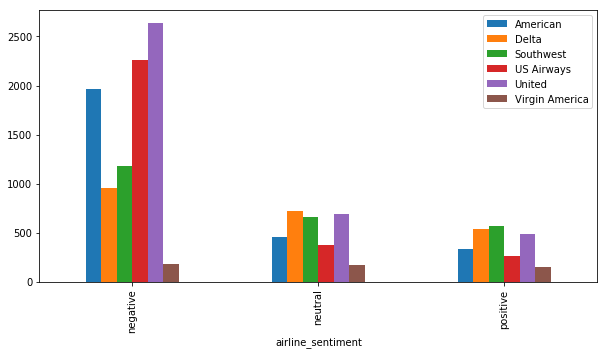

In [7]:
airline_sentiment = data.groupby('airline_sentiment').airline.apply(Counter)
airline_sentiment.unstack(level=1).plot(kind='bar', figsize = (10,5))
plt.show()

Overall speaking, negative sentiment accounts for the majority of tweets. Neutral and positive sentiments are much less than negative sentiment. Since people tend to express their feelings on social media when they are not statisfied with something, it makes sense that we have mostly negative sentiment. People who are satisfied with the service normally would not take time to write comment online.

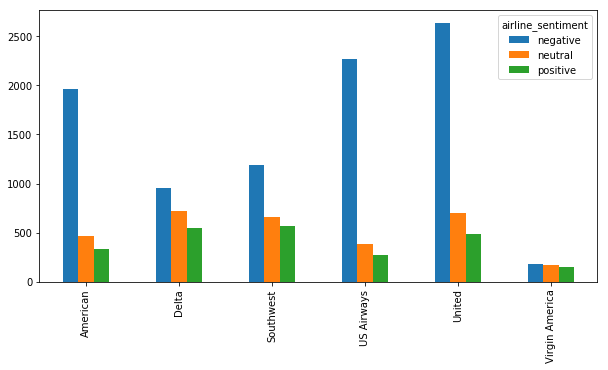

In [8]:
airline_sentiment.unstack(level=0).plot(kind='bar', figsize = (10,5))
plt.show()

We can see American, US Airways, United have REALLY unbalanced sentiments. Virgin American has most balanced sentiments but doesn't have many records since it's a relatively small airline compared to others

In [9]:
# Plot the count of each reason for negative tweets across airlines
def plot_neg_reason(airline):
    if airline =='all':
        neg_reason = data.groupby('negativereason').count()['airline_sentiment'].sort_values()
        neg_reason.plot(kind = 'bar')
        plt.xlabel('Negative Sentiment Reason for all airlines')
        plt.ylabel('Count')
        #plt.show()
    else:
        neg_reason = data.groupby(['airline','negativereason']).count()['airline_sentiment'][airline].sort_values()
        neg_reason.plot(kind = 'bar')
        plt.xlabel('Negative Sentiment Reason for {}'.format(airline))
        plt.ylabel('Count')
        #plt.show()

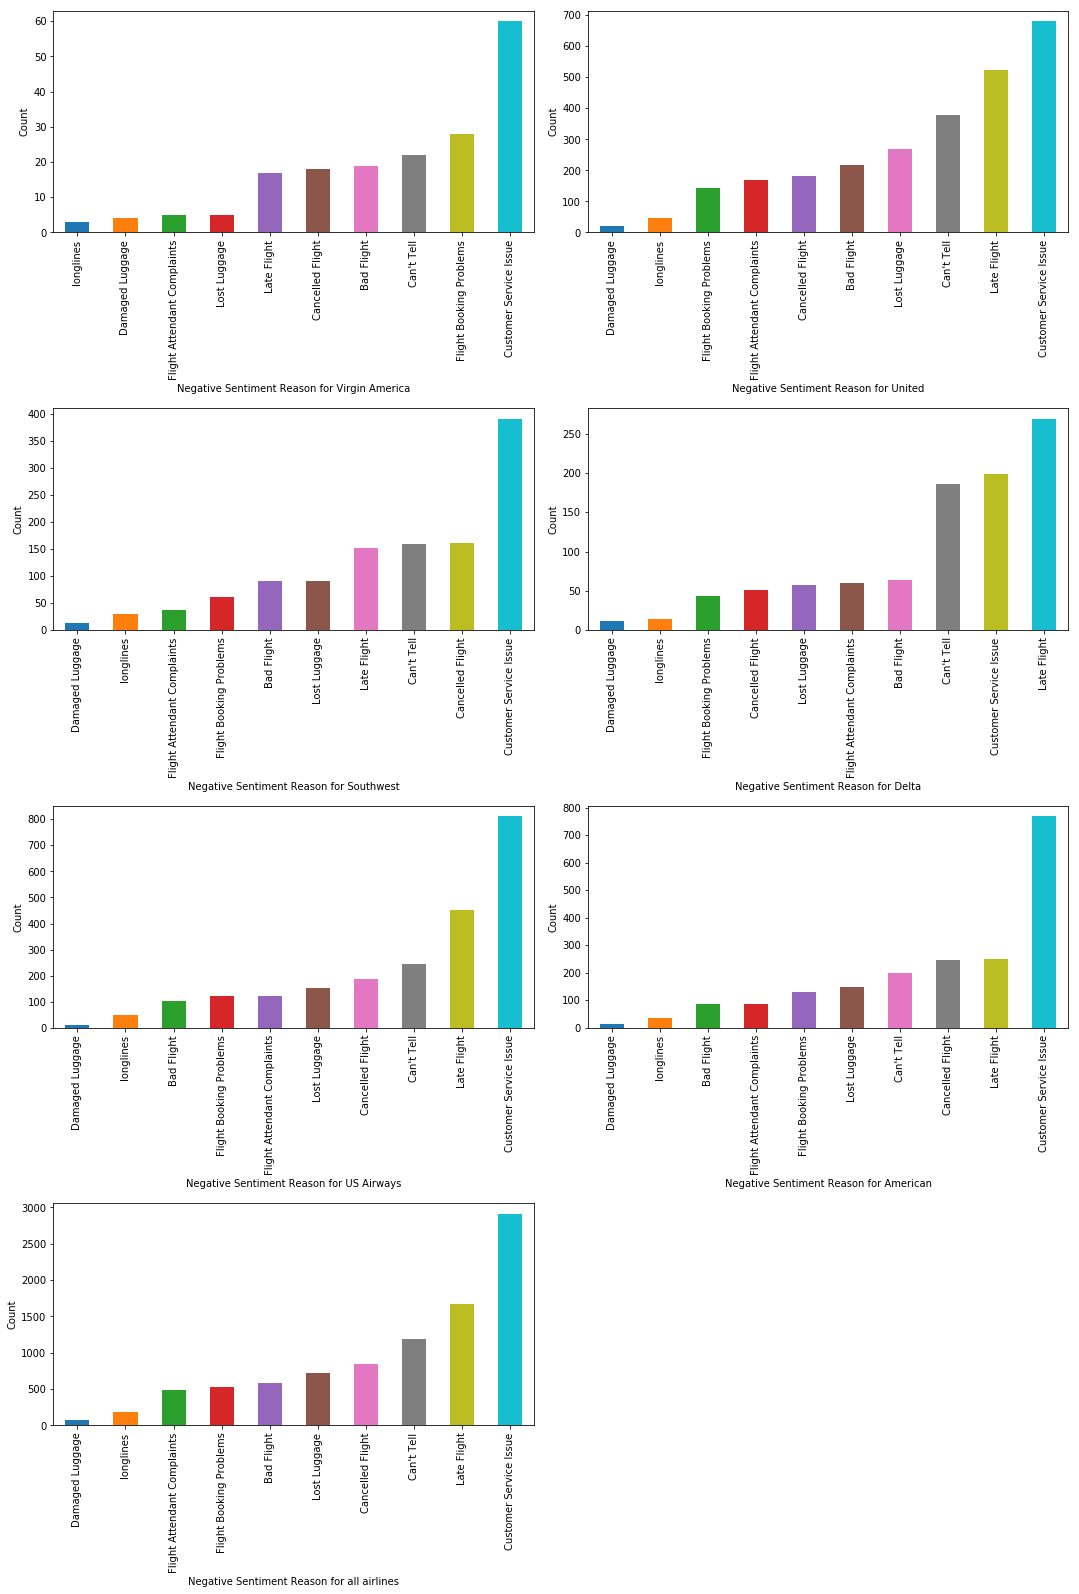

In [10]:
airlines = np.append(data['airline'].unique(),'all')
plt.figure(figsize=(15,20))
for i,airline in enumerate(airlines):
    plt.tight_layout()
    plt.subplot(4,2,i+1)
    plot_neg_reason(airline)
plt.show()

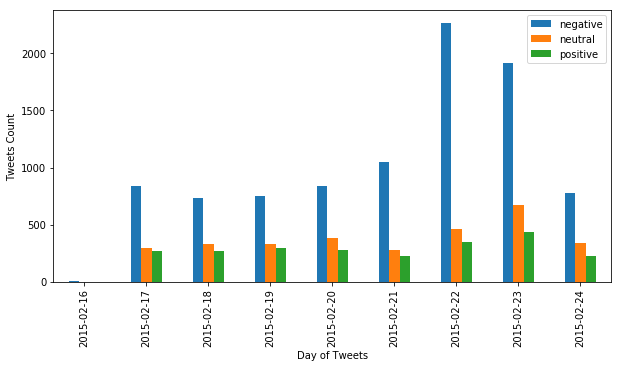

In [11]:
data_copy=data.copy()
data_copy['tweet_created']=data_copy['tweet_created'].map(lambda x: str(x)[:-15])
data_copy.groupby('tweet_created')['airline_sentiment'].apply(Counter).unstack().plot(kind='bar',figsize=(10,5))
plt.xlabel('Day of Tweets')
plt.ylabel('Tweets Count')
plt.show()

We can see that 02/22 (Sun) and 02/23 (Mon) have most tweets posted and most unbalanced sentiments. Even though we can't determine the cause of exploading negative sentiment on Sunday and Monday, we can say that there tend to be more travelers on these 2 days, which might be a cause to airport flight delay, busy check-in counter, inefficiecy to transport the luggage, etc.

## Data Engineering

In [12]:
def data_engineering(data):
    '''
    input: dataframe
    output: dataframe after preprocessing
    '''
    #data.shape  There are 14600 records
    df = data.copy()
    # We delete these 4 variables because either there are over 90% missing values and can be represented by other variables
    # or ID information we don't need
    del df['airline_sentiment_gold'], df['negativereason_gold'], df['tweet_coord'], df['tweet_id']
    
    # The statement below checks if all records labeled 'negative' have valid negative reason
    # df[df['airline_sentiment'] == 'negative']['negativereason'].isna().any()  This should print False
    
    # Thus, we want to fill 0 for positive sentiment since we have 0 confidence on these records to be negative
    df['negativereason_confidence'].fillna(-1, inplace=True)
    
    # df['tweet_created'].str.endswith('-0800').shape      
    # The stateabove should print (14600, ), which means all values in col 'tweet_created' end with '-8000'
    
    # Thus, we want to delete '-0800' since it doesn't provide extra information
    df['tweet_created'] = df['tweet_created'].map(lambda x: str(x)[:-6])
    
    # We set the index as date of these tweets created for future time series analysis
    df = df.set_index('tweet_created')
    df.index = pd.to_datetime(df.index)
    
    # We want to create dummy variables for nagative reason, airline and time zone since they are not ordinal
    neg_reasons = pd.get_dummies(df['negativereason'], prefix = 'negative_reason')
    df = pd.concat([df,neg_reasons],axis=1)
    airlines = pd.get_dummies(df['airline'],drop_first=True, prefix = 'airline')
    df = pd.concat([df, airlines], axis=1)
    timezones = pd.get_dummies(df['user_timezone'], prefix = 'timezone')
    df = pd.concat([df, timezones], axis=1)
    
    # Delete those variables we created dummies for, or information we don't need for future analysis
    del df['negativereason'],df['airline'], df['name'], df['tweet_location'], df['user_timezone'], df['text']
    
    # Finally, change sentiment to numerical values
    df['airline_sentiment'] = df['airline_sentiment'].map({'negative':1, 'neutral':2, 'positive':3})
    
    return df

In [13]:
df = data_engineering(data)

In [14]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason_confidence,retweet_count,negative_reason_Bad Flight,negative_reason_Can't Tell,negative_reason_Cancelled Flight,negative_reason_Customer Service Issue,negative_reason_Damaged Luggage,negative_reason_Flight Attendant Complaints,...,timezone_Stockholm,timezone_Sydney,timezone_Taipei,timezone_Tehran,timezone_Tijuana,timezone_Tokyo,timezone_Vienna,timezone_Warsaw,timezone_Wellington,timezone_West Central Africa
tweet_created,,,,,,,,,,,,,,,,,,,,,
2015-02-24 11:35:52,2,1.0000,-1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-24 11:15:59,3,0.3486,0.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-24 11:15:48,2,0.6837,-1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-24 11:15:36,1,1.0000,0.7033,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-24 11:14:45,1,1.0000,1.0000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's use mutual information to get an idea which variables contributes to sentiment the most

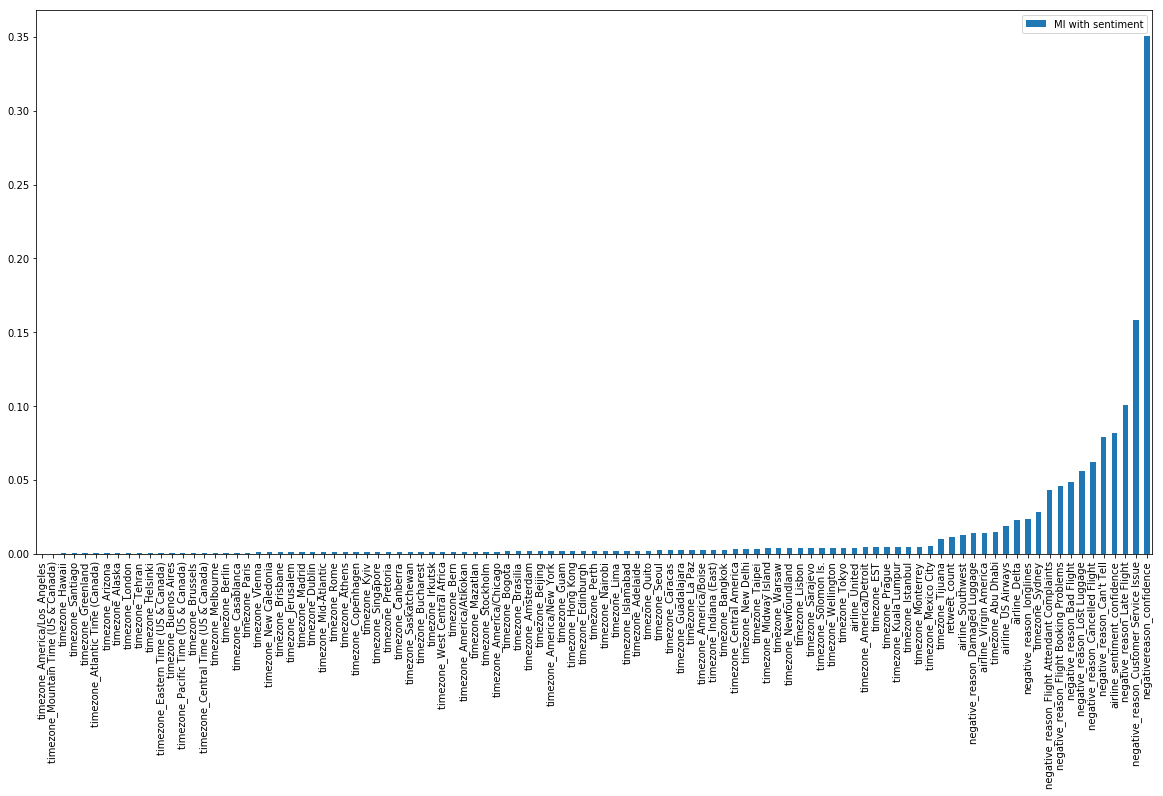

In [15]:
ml = []
for col in df.columns[1:]:
    ml.append(normalized_mutual_info_score(df[col], df['airline_sentiment']))
df_ml = pd.DataFrame(ml, index =df.columns[1:],columns = ['MI with sentiment'])
df_ml.sort_values(by= ['MI with sentiment']).plot.bar(figsize=(20,10))
plt.show()

We can see that `negative_reason_confidence` has the largest mutual information with `airline_sentiment`, but we know it's kinda cheating since it's another measure of sentiment and we don't know the algorithm to compute it. However, since we have this variable in our raw data, we might want to use it for better model performance.

In [16]:
# Implement LSA on the data to reduce dimension
# svd = TruncatedSVD(n_components=20, n_iter=10, random_state=42)
# df_svd = svd.fit_transform(df.iloc[:,1:])  

### Data Preparation

We have 14640 records for only 8 days in Feb, so each minute must have many records and we don't want to treat them as different time. Thus, we want to group our data by a period (window), which I pick 10 minutes after trials

In [17]:
# We want to predict the future week likelihood of the nagative sentiment for every 10 minutes 
groups_10Min = df.resample('10T')
mean_sentiment = np.mean(df['airline_sentiment'])
df_10M = groups_10Min.sum()
# Since we group by 10-min window, we want to compute the mean of airline_sentiment for the new data
# We fill those windows without any record with mean of sentiments
df_10M['airline_sentiment'] = (df_10M['airline_sentiment']/(groups_10Min['airline_sentiment'].count() + np.finfo(float).eps)).replace(0, mean_sentiment)


Since we only have 8-day tweets, we can't predict the next week sentiment based on the prior week. However, we can predict the next day sentiment based on the prior day. Even though our data show high negative sentiment on Sunday and Monday, we can still train our model by puting Sunday into train and Monday to test. Since we want full day records, we'll abandon data on 02/16 and 02/23, which are incomplete.

In [18]:
def split_df(df):
    # split into standard weeks
    train = pd.concat([df[3:579], df[723:867]]).values
    test = pd.concat([df[579:723], df[867:1011]]).values
                    
    # restructure into windows of weekly df
    train = np.array(np.split(train, len(train)/144))
    test = np.array(np.split(test, len(test)/144))
    return train, test

In [19]:
train, test = split_df(df_10M)

## Model

In [20]:
train.shape

(5, 144, 104)

### Multistep Time Series Forcasting with Machine Learning

We want to build a framework for evaluating different machine learning algorithms for multi-step time series forecasting using only `airline_sentiment` or all variables.

#### Evaluation Metric RMSE

In [21]:
# compute the RMSE of real and predicted values
def compute_rmse(real, pred):
    scores = list()
    # compute an RMSE for each 10 mins
    # n x 144
    for i in range(real.shape[1]):
        mse = mean_squared_error(real[:,i], pred[:,i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    
    # compute overal RMSE 
    s = 0
    for r in range(real.shape[0]):
        for c in range(real.shape[1]):
            s += (real[r,c] - pred[r,c])**2
    score = np.sqrt(s / (real.shape[0]*real.shape[1]))
    return score, scores

In [22]:
# print scores for that model called name
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

#### Machine Learning Models 

In [32]:
# models
def get_models(models = dict()):
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['rf'] = RandomForestRegressor()
    models['svm'] = SVR()
    models['xgboost'] = XGBRegressor(booster='gblinear')
    return models

#### Build a pipeline for feature and model

In [33]:
# create a pipeline for a model
def make_pipeline(model):
    steps = list()
    steps.append(('normalize', MinMaxScaler()))
    steps.append(('model', model))
    pipeline = Pipeline(steps=steps)
    return pipeline

#### Only use `airline_sentiment` 

In [34]:
# Turn airline_sentiment into series
def to_series(data):
    series = [day[:, 0] for day in data]
    # flatten into a single series
    series = np.array(series).flatten()
    return series

# Transform airline_sentiment to features and target for machine learning
def to_supervised(history, n_input):
    data = to_series(history)
    X, y = list(), list()
    ix_start = 0
    # step over the history one time step a time
    for i in range(len(data)):
        ix_end = ix_start + n_input
        if ix_end < len(data):
            X.append(data[ix_start: ix_end])
            y.append(data[ix_end])
            ix_start += 1
    return np.array(X), np.array(y)

# Make a recursive multi-step forecast
def forecast(model, input_x, n_input):
    yhat_seq = list()
    input_data = [x for x in input_x]
    for j in range(144):  # every hour has 6 10 minutes and there are 24 hours a day, giving 6*24 = 144 windows
        # prepare the input
        X = np.array(input_data[-n_input:]).reshape(1, n_input)
        #make a single-step forecast
        yhat = model.predict(X)[0]
        yhat_seq.append(yhat)
        # append the yhat to the input for next round of prediction, aka sliding window
        input_data.append(yhat)
    return yhat_seq

# fit and predict
def fit_predict(model, history, n_input): 
    # train_x: an array of list
    # train_y: an array of the next sentiment after the corresponding list in train_x
    train_x, train_y = to_supervised(history, n_input)
    pipeline = make_pipeline(model)
    pipeline.fit(train_x, train_y)
    yhat_seq = forecast(pipeline, train_x[-1,:], n_input)
    return yhat_seq, pipeline


# Evaluation of model
def evaluate(model, train, test, n_input):
    # history is a list of 10min-binned data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # prdict the next 10 min
        yhat_seq, pipeline = fit_predict(model, history, n_input)
        predictions.append(yhat_seq)
        history.append(test[i,:])
    predictions = np.array(predictions)
    score, scores = compute_rmse(test[:,:,0], predictions)
    return score, scores, pipeline, predictions

lr: [0.333] 0.3, 0.2, 0.6, 0.3, 0.6, 0.3, 1.2, 0.3, 0.3, 0.2, 0.3, 0.2, 0.1, 0.4, 0.2, 1.2, 0.2, 0.8, 0.3, 0.9, 0.2, 0.4, 0.2, 0.3, 0.5, 0.3, 0.6, 0.3, 0.1, 0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.1, 0.4, 0.2, 0.2, 0.0, 0.2, 0.5, 0.2, 0.1, 0.2, 0.2, 0.3, 0.2, 0.3, 0.2, 0.1, 0.2, 0.4, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.2, 0.3, 0.3, 0.0, 0.5, 0.3, 0.0, 0.6, 0.4, 0.5, 0.3, 0.4, 0.1, 0.1, 0.4, 0.5, 0.1, 0.0, 0.3, 0.3, 0.3, 0.1, 0.1, 0.2, 0.2, 0.5, 0.3, 0.1, 0.1, 0.4, 0.2, 0.3, 0.1, 0.4, 0.1, 0.6, 0.0, 0.5, 0.2, 0.2, 0.3, 0.5, 0.4, 0.4, 0.2, 0.4, 0.2, 0.1, 0.1, 0.3, 0.4, 0.3, 0.2, 0.1, 0.2, 0.1, 0.2, 0.6, 0.2, 0.2, 0.1, 0.1, 0.2, 0.0, 0.2, 0.1, 0.4, 0.1, 0.1, 0.1, 0.2, 0.3, 0.1, 0.3, 0.6, 0.2, 0.5, 0.1, 0.1, 0.2, 0.2
lasso: [0.294] 0.5, 0.4, 0.6, 0.2, 0.4, 0.4, 1.0, 0.3, 0.5, 0.1, 0.4, 0.4, 0.2, 0.5, 0.1, 1.0, 0.4, 0.6, 0.1, 0.7, 0.4, 0.3, 0.1, 0.2, 0.4, 0.2, 0.3, 0.2, 0.3, 0.2, 0.1, 0.2, 0.1, 0.4, 0.2, 0.4, 0.2, 0.1, 0.4, 0.2, 0.3, 0.3, 0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.1, 0.3, 0.3,

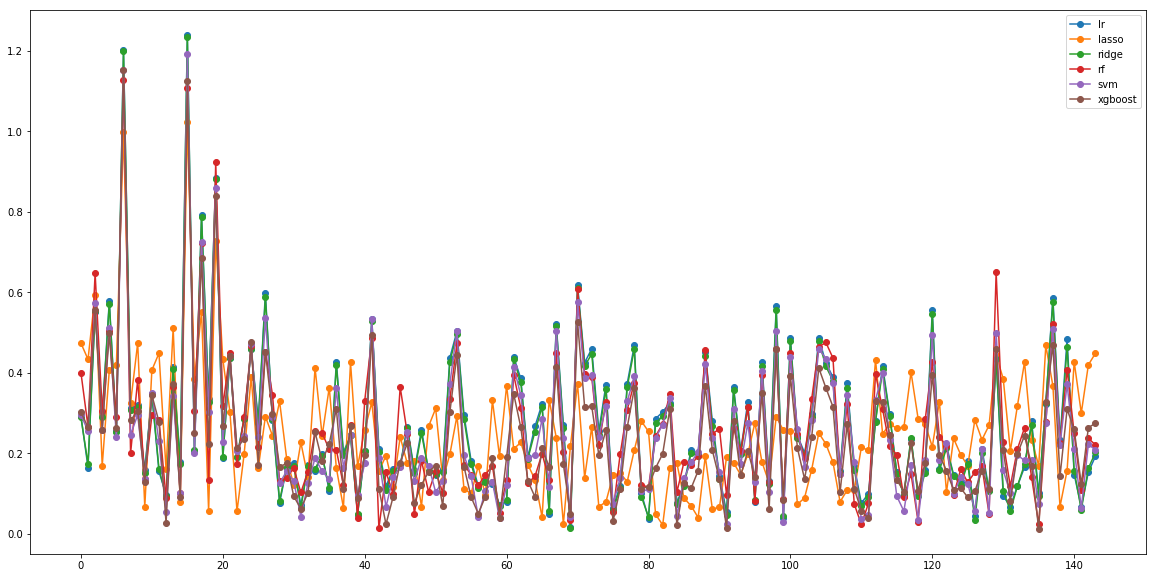

In [35]:
models = get_models()
n_input = 144
# evaluate each model
mins = np.arange(0,144,1)
plt.figure(figsize=(20,10))
m = dict()
pred = dict()
for name, model in models.items():
    # evaluate and get scores
    score, scores, m[name], pred[name] = evaluate(model, train, test, n_input)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    plt.plot(mins, scores, marker='o', label=name)
# show plot
plt.legend()
plt.show()

In [27]:
# Check model
# print(m['lr'].predict(test[0][:,0].reshape(1,144)))
# print(test[1][0,0])

#### Use all variables for our multi-step forecast

In [36]:
def to_supervised(history, output_ix):
    X, y = list(), list()
    # step over the entire history one time step at a time
    for i in range(len(history)-1):
        X.append(history[i].flatten())
        y.append(history[i + 1][output_ix,0])
    return np.array(X), np.array(y)

def fit_predict(model, history):
    yhat_sequence = list()
    models = []
    # fit a model for each forecast day
    for i in range(144):
        # prepare data
        train_x, train_y = to_supervised(history, i)
        # make pipeline
        pipeline = make_pipeline(model)
        # fit the model
        pipeline.fit(train_x, train_y)
        models.append(pipeline)
        # forecast
        x_input = np.array(train_x[-1, :]).reshape(1,14976)
        yhat = pipeline.predict(x_input)[0]
        # store
        yhat_sequence.append(yhat)
    return yhat_sequence, models

# Evaluation of model
def evaluate_model(model, train, test):
    # history is a list of 10min-binned data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    m = []
    for i in range(len(test)):
        # prdict the next 10 min
        yhat_seq, models = fit_predict(model, history)
        predictions.append(yhat_seq)
        history.append(test[i,:])
    m.append(models)
    predictions = np.array(predictions)
    score, scores = compute_rmse(test[:,:,0], predictions)
    return score, scores, m, predictions

lr: [0.386] 0.2, 0.5, 0.8, 0.3, 0.9, 0.4, 1.6, 0.3, 0.2, 0.1, 0.5, 0.5, 0.3, 0.5, 0.4, 1.0, 0.5, 1.2, 0.4, 1.5, 0.3, 0.7, 0.1, 0.5, 0.7, 0.2, 0.5, 0.4, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.3, 0.2, 0.3, 0.1, 0.4, 0.2, 0.2, 0.6, 0.2, 0.1, 0.1, 0.2, 0.3, 0.2, 0.1, 0.4, 0.1, 0.2, 0.3, 0.5, 0.1, 0.1, 0.0, 0.2, 0.2, 0.1, 0.2, 0.3, 0.3, 0.2, 0.2, 0.3, 0.4, 0.3, 0.3, 0.3, 0.7, 0.1, 0.4, 0.1, 0.3, 0.1, 0.2, 0.1, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1, 0.3, 0.2, 0.1, 0.1, 0.4, 0.2, 0.3, 0.3, 0.3, 0.2, 0.6, 0.1, 0.5, 0.4, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1, 0.2, 0.1, 0.1, 0.0, 0.5, 0.3, 0.4, 0.1, 0.0, 0.3, 0.0, 0.4, 0.6, 0.3, 0.2, 0.1, 0.2, 0.1, 0.2, 0.3, 0.1, 0.7, 0.3, 0.3, 0.3, 0.2, 0.4, 0.2, 0.2, 0.6, 0.2, 0.4, 0.3, 0.2, 0.4, 0.5
lasso: [0.316] 0.9, 0.6, 0.6, 0.3, 0.6, 0.3, 0.8, 0.3, 0.4, 0.1, 0.3, 0.4, 0.3, 0.4, 0.1, 1.0, 0.5, 0.7, 0.2, 0.8, 0.2, 0.3, 0.1, 0.2, 0.5, 0.2, 0.3, 0.3, 0.6, 0.2, 0.1, 0.2, 0.2, 0.6, 0.2, 0.3, 0.2, 0.2, 0.3, 0.2, 0.3, 0.2, 0.2, 0.2, 0.1, 0.3, 0.3, 0.1, 0.1, 0.3, 0.3,

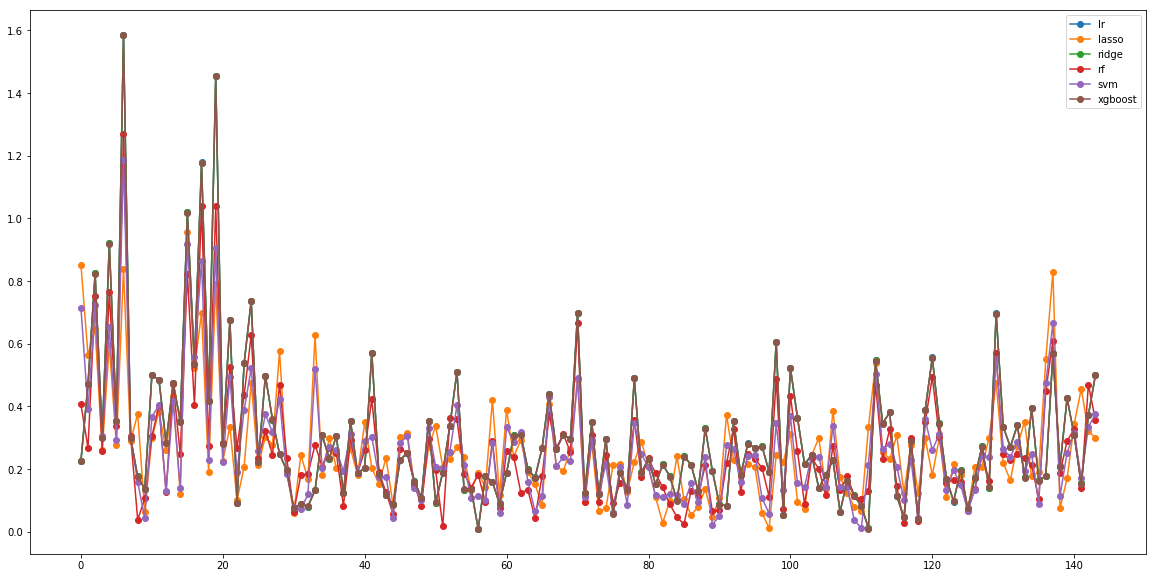

In [38]:
models = get_models()
# evaluate each model
mins = np.arange(0,144,1)
plt.figure(figsize=(20,10))
mm = dict()
pred = dict()
for name, model in models.items():
    # evaluate and get scores
    score, scores, mm[name], pred[name] = evaluate_model(model, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    plt.plot(mins, scores, marker='o', label=name)
# show plot
plt.legend()
plt.show()

## Results

From two plots above, we can see Lasso performs best in both settings. One thing need to be noted is that after we use all features, the performance actually drops. This happens when we have sparse feature space, so further data engineering is required. Also, we just use the default setting for our choice of models, of which the permence could be improved a lot using cross validation.